### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [90]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96, 1)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data.iloc[:, :-1].to_numpy()

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [29]:
# 讀取資料
DATA_ROOT = "Facial_Keypoints_Detection"
training_file = os.path.join(DATA_ROOT,"training.csv" )
imgs_train, points_train = load_data(dirname = training_file)
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96, 1) 
關鍵點資料: (2140, 30)


In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras
from keras.preprocessing.image import ImageDataGenerator

In [19]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [ ]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# 印出網路結構
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [ ]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

In [ ]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [ ]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [84]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

In [ ]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦

In [41]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [42]:
split=int(imgs_train.shape[0]*0.8)

x_train = imgs_train[:split]
y_train = points_train[:split]

x_val = imgs_train[split:]
y_val = points_train[split:]

train_datagen = ImageDataGenerator(
    horizontal_flip=True)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
val_generator = train_datagen.flow(x_val, y_val, batch_size=32, shuffle=False)


In [45]:
history = model_with_augment.fit_generator(train_generator,
                                           steps_per_epoch=len(x_train)//32, 
                                           validation_data = val_generator,
                                           validation_steps = len(x_val)//32,                                           
                                           epochs=20)

Epoch 1/20
53/53 [==============================] - 2s 43ms/step - loss: 0.0039 - mean_absolute_error: 0.0436 - val_loss: 0.0019 - val_mean_absolute_error: 0.0327
Epoch 2/20
53/53 [==============================] - 1s 23ms/step - loss: 0.0013 - mean_absolute_error: 0.0277 - val_loss: 0.0019 - val_mean_absolute_error: 0.0328
Epoch 3/20
53/53 [==============================] - 1s 19ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - val_loss: 0.0019 - val_mean_absolute_error: 0.0326
Epoch 4/20
53/53 [==============================] - 1s 19ms/step - loss: 9.7376e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314
Epoch 5/20
53/53 [==============================] - 1s 19ms/step - loss: 7.9056e-04 - mean_absolute_error: 0.0212 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309
Epoch 6/20
53/53 [==============================] - 1s 20ms/step - loss: 6.8892e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0016 - val_mean_absolute_error: 0.0297
Epoch 7/20

Text(0, 0.5, 'MAE')

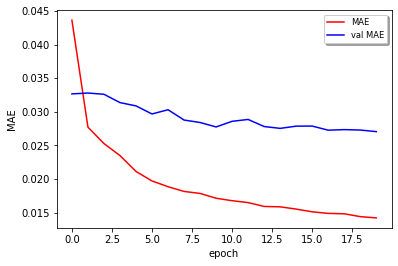

In [46]:
fig, ax = plt.subplots()
ax.plot(history.history["mean_absolute_error"], "red", label="MAE")
ax.plot(history.history["val_mean_absolute_error"], "blue", label="val MAE")
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
ax.set_xlabel("epoch")
ax.set_ylabel("MAE")

In [132]:
test_file = os.path.join(DATA_ROOT, "test.csv")
imgs_test, _ = load_data(dirname = test_file)


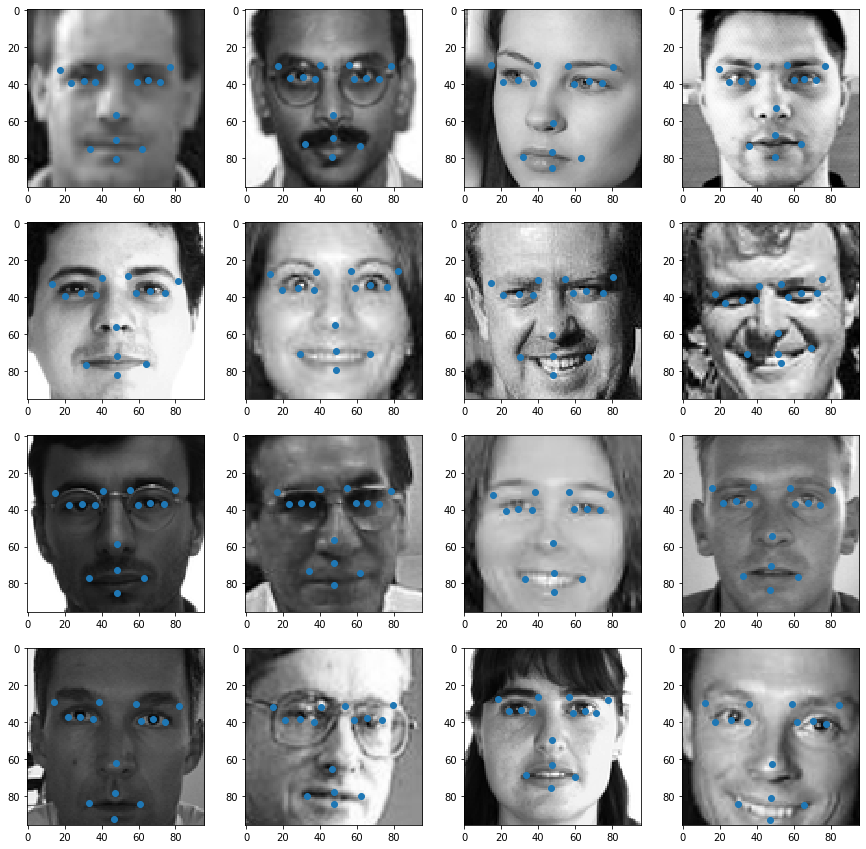

In [150]:

indexes = np.random.randint(0, imgs_test.shape[0], size=16) # random 16 test images 
plt.figure(figsize=(15,15))

for i, idx in enumerate(indexes): 
    points= model_with_augment.predict(imgs_test[idx].reshape(-1, 96,96,1))
    p= np.squeeze(points)  # points.shape=(1,30), squeeze axis=0
    p = (p + 0.5) *96  
    x = p[0::2]   #even points
    y = p[1::2]   # odd points
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs_test[idx].reshape(96,96), cmap='gray')
    plt.scatter(x,y)